# Clinical NLP Workflow Demonstration

This notebook demonstrates the end-to-end workflow for processing synthetic clinical data:
1. ETL: Load and clean data
2. NLP: Extract disease phenotypes and symptoms
3. Analysis: Visualize and summarize results


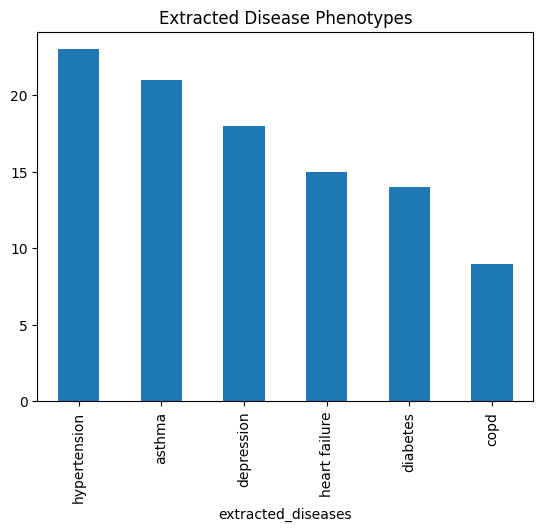

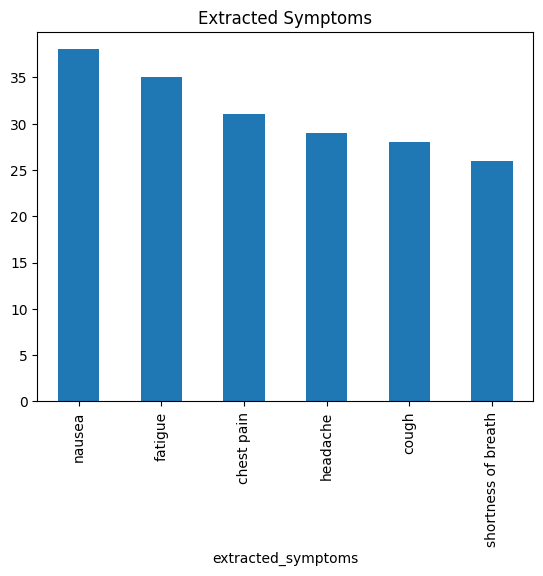

,clinical_note,extracted_diseases,extracted_symptoms
0,Patient presents with cough. History of diabetes.,[diabetes],[cough]
1,"Patient presents with headache, fatigue. Histo...",[asthma],"[fatigue, headache]"
2,Patient presents with chest pain. History of d...,[diabetes],[chest pain]
3,"Patient presents with nausea, headache. Histor...",[hypertension],"[headache, nausea]"
4,Patient presents with fatigue. History of diab...,[diabetes],[fatigue]


In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os
sys.path.append(os.path.abspath("../src"))
from etl_pipeline import etl_process
from nlp_pipeline import nlp_process

# Define disease and symptom lists
DISEASES = ["diabetes", "hypertension", "asthma", "copd", "heart failure", "depression"]
SYMPTOMS = ["fatigue", "cough", "chest pain", "shortness of breath", "headache", "nausea"]

# ETL: Load and clean data
df = etl_process("../data/synthetic_clinical_data.csv")

# NLP: Extract phenotypes and symptoms
df = nlp_process(df, DISEASES, SYMPTOMS)

# Analysis: Disease frequency
phenotype_counts = df.explode("extracted_diseases")["extracted_diseases"].value_counts()
phenotype_counts.plot(kind="bar", title="Extracted Disease Phenotypes")
plt.show()

# Analysis: Symptom frequency
symptom_counts = df.explode("extracted_symptoms")["extracted_symptoms"].value_counts()
symptom_counts.plot(kind="bar", title="Extracted Symptoms")
plt.show()

# Show sample results
df[["clinical_note", "extracted_diseases", "extracted_symptoms"]].head()

## Advanced NLP: Named Entity Recognition with spaCy

In this section, we use spaCy to extract medical entities from clinical notes and compare with rule-based extraction.

In [19]:
import spacy
from spacy.tokens import DocBin

# Load spaCy's English model
nlp = spacy.load("en_core_web_sm")

# Example: Run NER on first 5 clinical notes
docs = list(nlp.pipe(df["clinical_note"].head()))
for i, doc in enumerate(docs):
    print(f"Note {i+1}:", doc.text)
    for ent in doc.ents:
        print(f"  Entity: {ent.text} | Label: {ent.label_}")
    print()

Note 1: Patient presents with cough. History of diabetes.

Note 2: Patient presents with headache, fatigue. History of asthma.

Note 3: Patient presents with chest pain. History of diabetes.

Note 4: Patient presents with nausea, headache. History of hypertension.

Note 5: Patient presents with fatigue. History of diabetes.



## Predictive Modeling: Disease Risk Classification

In this section, we build a simple classifier to predict disease risk using patient demographics and extracted features.

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
import numpy as np

# Create binary target: diabetes vs. others
df["diabetes_risk"] = (df["disease"] == "diabetes").astype(int)

# Feature engineering: age, gender, symptom count
X = pd.DataFrame({
    "age": df["age"],
    "gender": (df["gender"] == "M").astype(int),
    "symptom_count": df["extracted_symptoms"].apply(lambda x: len(x) if isinstance(x, list) else 0)
})
y = df["diabetes_risk"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train logistic regression
clf = LogisticRegression()
clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))

              precision    recall  f1-score   support

           0       0.85      1.00      0.92        17
           1       0.00      0.00      0.00         3

    accuracy                           0.85        20
   macro avg       0.42      0.50      0.46        20
weighted avg       0.72      0.85      0.78        20

ROC AUC: 0.8627450980392156


/Users/justin/nlp_clincal/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/justin/nlp_clincal/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/justin/nlp_clincal/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

In [21]:
# Class balancing using class_weight='balanced' in LogisticRegression
# Additional features: include spaCy entity count and one-hot encoding for disease
from sklearn.preprocessing import OneHotEncoder

# Feature: spaCy entity count per note
entity_counts = []
for note in df["clinical_note"]:
    doc = nlp(note)
    entity_counts.append(len(doc.ents))
df["entity_count"] = entity_counts

# One-hot encode disease
encoder = OneHotEncoder(sparse_output=False)
disease_ohe = encoder.fit_transform(df[["disease"]])
disease_ohe_df = pd.DataFrame(disease_ohe, columns=encoder.get_feature_names_out(["disease"]))

# Combine features
X = pd.concat([
    pd.DataFrame({
        "age": df["age"],
        "gender": (df["gender"] == "M").astype(int),
        "symptom_count": df["extracted_symptoms"].apply(lambda x: len(x) if isinstance(x, list) else 0),
        "entity_count": df["entity_count"]
    }),
    disease_ohe_df
], axis=1)
y = df["diabetes_risk"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train balanced logistic regression
clf = LogisticRegression(class_weight='balanced')
clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       1.00      1.00      1.00         3

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20

ROC AUC: 1.0


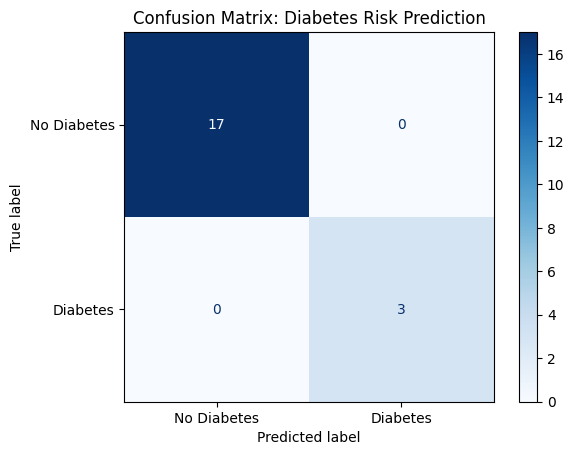

Model Coefficients (sorted):
                 Feature  Coefficient
7       disease_diabetes     3.666316
0                    age    -0.004299
1                 gender    -0.241209
2          symptom_count    -0.306887
3           entity_count    -0.436632
4           disease_COPD    -0.436632
8  disease_heart failure    -0.769058
9   disease_hypertension    -0.770615
6     disease_depression    -0.817216
5         disease_asthma    -0.873065


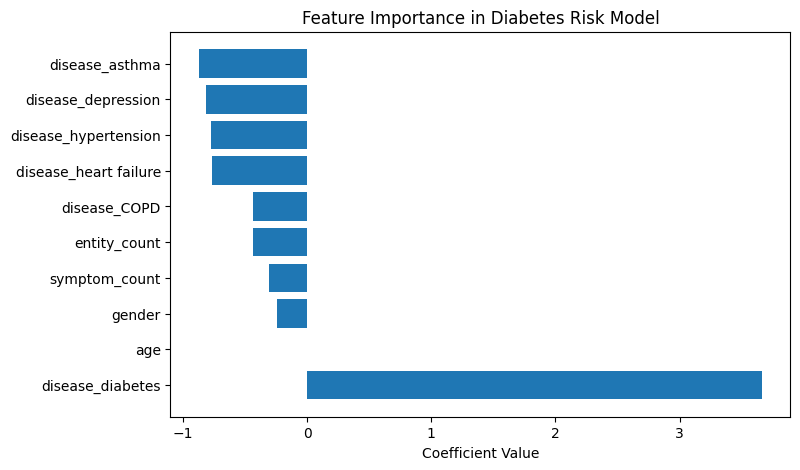

In [22]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Visualize confusion matrix
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, display_labels=["No Diabetes", "Diabetes"], cmap=plt.cm.Blues)
plt.title("Confusion Matrix: Diabetes Risk Prediction")
plt.show()

# Interpret model coefficients
feature_names = X.columns
coefficients = clf.coef_[0]
coef_df = pd.DataFrame({"Feature": feature_names, "Coefficient": coefficients})
coef_df = coef_df.sort_values(by="Coefficient", ascending=False)
print("Model Coefficients (sorted):")
print(coef_df)

# Visualize coefficients
plt.figure(figsize=(8, 5))
plt.barh(coef_df["Feature"], coef_df["Coefficient"])
plt.xlabel("Coefficient Value")
plt.title("Feature Importance in Diabetes Risk Model")
plt.show()

### Model Evaluation: Confusion Matrix
The confusion matrix above shows the number of correct and incorrect predictions for diabetes risk. It helps assess how well the model distinguishes between patients with and without diabetes.
### Feature Importance: Model Coefficients
The bar plot and table display the coefficients learned by the logistic regression model. Positive values indicate features that increase the likelihood of diabetes, while negative values decrease it. This helps interpret which patient characteristics and extracted features are most predictive.

## Project Summary and Next Steps

This notebook demonstrates a clinical NLP and predictive modeling workflow using synthetic data. Key steps include:
- ETL and data cleaning for structured and unstructured clinical data
- Rule-based and spaCy-based NLP for phenotype and entity extraction
- Predictive modeling for disease risk using patient features and NLP outputs
- Model evaluation and interpretation with visualizations

**Clinical Relevance:**
- The workflow simulates real-world tasks in clinical research and healthcare analytics, such as identifying disease phenotypes and predicting patient risk.
- Feature importance analysis helps clinicians and researchers understand which factors contribute most to disease risk.

**Limitations:**
- Synthetic data may not capture all complexities of real clinical data.
- The NLP pipeline can be further improved with domain-specific models and negation/context handling.
- Predictive modeling can be enhanced with more features and advanced algorithms.

**Next Steps:**
- Integrate real or more complex synthetic datasets
- Expand NLP with custom entity recognition and context analysis
- Explore additional models (e.g., random forest, XGBoost)
- Add privacy/compliance checks and reporting modules

For questions or collaboration, please contact the project owner.